In [96]:
import matplotlib.pyplot as plt
from numpy.random import uniform
import torch
from torch.distributions import multivariate_normal
import torch.autograd as autograd
import torch.optim as optim
import time
import multiprocessing
from joblib import Parallel, delayed
from tqdm import tqdm
from math import ceil
import torch.nn as nn
from math import sqrt
import numpy as np

In [97]:
def U(configuration, energy_parameters):
    J, mu, h, theta = energy_parameters
    """
    Takes the (torch format) 3D lattice (as a 1D tensor), the coupling constants, 
    and the magnetic field value (along theta). Returns the total energy of the system.
    """
    N = ceil(len(configuration) ** (1 / 3))  # Assuming the input lattice is a cube
    lattice = configuration.view(N, N, N)

    # Interaction along depth dimension (third dimension)
    J_interaction_depth = - J * torch.sum(torch.cos(lattice - torch.roll(lattice, shifts=1, dims=2)))

    # Interaction along rows (first dimension)
    J_interaction_rows = - J * torch.sum(torch.cos(lattice - torch.roll(lattice, shifts=1, dims=0)))

    # Interaction along columns (second dimension)
    J_interaction_columns = - J * torch.sum(torch.cos(lattice - torch.roll(lattice, shifts=1, dims=1)))

    # Magnetic field coupling
    h_coupling = - mu * h * torch.sum(torch.cos(lattice - theta))

    total_energy = h_coupling + J_interaction_depth + J_interaction_rows + J_interaction_columns + h_coupling
    return total_energy

#boundary conditions
def BC(configuration):
    N = ceil(len(configuration) ** (1/3))
    configuration = configuration%(2*torch.pi)
    config_clone = configuration.clone()
    new = config_clone.view(N,N,N)
    new[0,:,:] = new[-1,:,:]
    new[:,0,:] = new[:,-1,:]
    new[:,:,0] = new[:,:,-1]
    return config_clone

#XY model, d2n1 (2D vector on 1D lattice)
def U(configuration, energy_parameters):
    J, mu, h, theta = energy_parameters
    """takes the (torch format) 1D lattice, the coupling constants and the magnetic field value (along theta)
    returns the total energy of the system"""
    h_coupling = - mu*h*torch.sum(torch.cos(configuration - theta)[:-1])
    J_interaction = - J*torch.sum((torch.cos(configuration - torch.roll(configuration, shifts = 1)))[:-1])
    return h_coupling + J_interaction

#boundary conditions (2D vector on 1D lattice)
def BC(configuration):
    configuration = configuration%(2*torch.pi)
    copy_config = torch.zeros_like(configuration)
    copy_config[-1] = configuration[0]-configuration[-1]
    return configuration+copy_config

# U + boundary conditions implicit. 
def U(configuration, energy_parameters):
    J, mu, h, theta = energy_parameters
    h_coupling = - mu * h * torch.sum(torch.cos(configuration - theta))
    J_interaction = - J * torch.sum(torch.cos(configuration - torch.roll(configuration, shifts=-1)))
    # Adding interaction between the first and last spins
    J_interaction += - J * torch.cos(configuration[0] - configuration[-1])
    return h_coupling + J_interaction

In [98]:
class PlanarFlow(nn.Module):

    def __init__(self, data_dim):
        super().__init__()

        self.u = nn.Parameter(torch.rand(data_dim)/sqrt(data_dim))
        self.w = nn.Parameter(torch.rand(data_dim)/sqrt(data_dim))
        self.b = nn.Parameter(torch.rand(1)/sqrt(data_dim))
        self.h = nn.Tanh()
    
    def h_prime(self, z):
        return 1 - self.h(z) ** 2
    
    def constrained_u(self):
        """
        Constrain the parameters u to ensure invertibility
        """
        wu = torch.matmul(self.w.T, self.u)
        m = lambda x: -1 + torch.log(1 + torch.exp(x))
        return self.u + (m(wu) - wu) * (self.w / (torch.norm(self.w) ** 2 + 1e-15))
    
    def forward(self, z):
        u = self.constrained_u()
        hidden_units = torch.matmul(self.w.T, z.T) + self.b

        x = z + u.unsqueeze(0) * self.h(hidden_units).unsqueeze(-1)

        psi = self.h_prime(hidden_units).unsqueeze(0) * self.w.unsqueeze(-1)

        log_det = torch.log((1+torch.matmul(u.T, psi)).abs() + 1e-15)

        return x, log_det

    def inverse(self, x):
        u = self.constrained_u()
        hidden_units = (torch.matmul(self.w.T, x.T) + self.b).T
        z = x - u.unsqueeze(0) * self.h(hidden_units).unsqueeze(-1)
        psi = self.h_prime(hidden_units).unsqueeze(0) * self.w.unsqueeze(-1)
        log_det = -torch.log((1 + torch.matmul(u.T, psi)).abs() + 1e-15)
        return z, log_det

class LayeredPlanarFlow(nn.Module):

    def __init__(self, data_dim, flow_length = 16):
        super().__init__()

        self.layers = nn.Sequential(
            *(PlanarFlow(data_dim) for _ in range(flow_length)))

    def forward(self, z):
        log_det_sum = 0
        for layer in self.layers:
            z, log_det = layer(z)
            log_det_sum += log_det
        return z, log_det_sum
    
    def inverse(self, z):
        log_det_sum = 0
        for layer in self.layers:
            z, log_det = layer.inverse(z)
            log_det_sum += log_det
        return z, log_det_sum

In [13]:
def NF_MCMC_algorithm(beta, U, BC, energy_parameters, flow, initial_data, base_distribution, time_step, k_max, k_lang, epsilon):
    #all operations must act on the whole array of lattices, hence proposed_model_configuration_amongst_zeros and other weird stuff
    
    def gradU(configuration):
        return autograd.grad(U(configuration, energy_parameters), configuration)[0]

    n, N = initial_data.shape

    normal_distribution_for_langevin = multivariate_normal.MultivariateNormal(loc=torch.zeros(N), covariance_matrix=torch.eye(N))

    array_of_model_configurations = torch.zeros(k_max,n,N)
    array_of_model_configurations[0] = initial_data
    array_of_model_configurations.requires_grad = True

    optimizer = optim.Adam(flow.parameters(), lr=epsilon)

    history = torch.zeros(k_max, n)
    #history[k,i] = 0 => Dynamic Langevin step
    #history[k,i] = 1 => Static Langevin step
    #history[k,i] = 2 => Dynamic Flow step
    #history[k,i] = 3 => Static Flow step

    for k in tqdm(range(1,k_max)):
        for i in range(n):
            proposed_model_configuration_amongst_zeros = torch.zeros(k_max,n,N)
            if k % k_lang == 0:
                history[k,i] += 2
                proposed_model_configuration_amongst_zeros[k,i] = flow(base_distribution.sample())[0]
                
                #proposed_model_configuration_amongst_zeros[k,i] = BC(proposed_model_configuration_amongst_zeros[k,i])

                acceptance_rate = torch.exp(log_rho_hat(array_of_model_configurations[k-1,i])
                                            - log_rho_hat(proposed_model_configuration_amongst_zeros[k,i])
                                            + beta*U(array_of_model_configurations[k-1, i], energy_parameters)
                                            - beta*U(proposed_model_configuration_amongst_zeros[k, i], energy_parameters))

            else:
                proposed_model_configuration_amongst_zeros[k,i] = ( array_of_model_configurations[k-1,i]
                                                                    - time_step * gradU(array_of_model_configurations[k-1, i])
                                                                    + torch.sqrt(2*torch.tensor(time_step)) * normal_distribution_for_langevin.sample())

                #proposed_model_configuration_amongst_zeros[k,i] = BC(proposed_model_configuration_amongst_zeros[k,i])

                acceptance_rate = torch.exp(beta*U(array_of_model_configurations[k-1, i], energy_parameters)
                                            - beta*U(proposed_model_configuration_amongst_zeros[k, i], energy_parameters))

            if uniform() > acceptance_rate:
                    proposed_model_configuration_amongst_zeros[k,i] = array_of_model_configurations[k-1,i]
                    history[k,i] += 1
            array_of_model_configurations = array_of_model_configurations + proposed_model_configuration_amongst_zeros
        
        #def log_rho_hat(x):
            #return base_distribution.log_prob((flow.inverse(x))[0])+flow.inverse(x)[1]
        
        def log_rho_hat(x):
            # Ensure x is valid for flow.inverse and log_prob
            x_inv, log_det = flow.inverse(x)
            # Check for NaNs in x_inv and log_det
            if torch.isnan(x_inv).any() or torch.isnan(log_det).any():
                raise ValueError("NaN values detected in flow.inverse outputs.")
            return base_distribution.log_prob(x_inv) + log_det
        
        #OPTIMISATION
        #optimizer.zero_grad()
        #x = array_of_model_configurations[k-1,:].clone().detach().requires_grad_(False)
        #loss = - (base_distribution.log_prob(flow.inverse(x)[0]) + flow.inverse(x)[1]).mean()
        #loss.backward()
        #optimizer.step()
        
        # OPTIMISATION
        optimizer.zero_grad()
        x = array_of_model_configurations[k-1, :].clone().detach().requires_grad_(False)

        # Ensure x is valid for flow.inverse
        x_inv, inv_log_det = flow.inverse(x)
        if torch.isnan(x_inv).any() or torch.isnan(inv_log_det).any():
            raise ValueError("NaN values detected in flow.inverse outputs.")

        loss = - (base_distribution.log_prob(x_inv) + inv_log_det).mean()
        if torch.isnan(loss):
            raise ValueError("NaN values detected in loss calculation.")

        loss.backward()
        optimizer.step()
    
    return history, array_of_model_configurations.detach()

In [92]:
# MODEL PARAMETERS

d = 1
data_dim = 1000**d #size of the parameter space, N
beta = 1e3
h = 0
J = 1
energy_parameters = [J, 1, h, 0] # J, mu, h, theta]

# RF PARAMETERS
n = 10 #number of initial samples
#base_distribution = multivariate_normal.MultivariateNormal(loc=torch.zeros(data_dim), covariance_matrix=beta*h*torch.eye(data_dim))
#normalizing_flow = LayeredPlanarFlow(data_dim)
epsilon = 1e-2 #gradient descent rate for RF parameters

# MALA PARAMETERS
time_step = 0.01
k_lang = 20

# INITIALISATION
initial_data = torch.rand(n*data_dim).reshape(n,data_dim)*20-10
k_max = 200

# RUN
RF_MCMC_parameters = [time_step, k_max, k_lang, epsilon]
#history, array_of_model_configurations = NF_MCMC_algorithm(beta, U, BC, energy_parameters, normalizing_flow, initial_data, base_distribution, *RF_MCMC_parameters)

In [93]:
avg_size = 1000

def magnet(beta):
    K = beta*(h + 2*J)*torch.eye(data_dim)
    K[torch.arange(data_dim), torch.roll(torch.arange(data_dim), shifts=1)] = -2 * beta * J
    K[torch.roll(torch.arange(data_dim), shifts=1), torch.arange(data_dim)] = -2* beta * J 
    base_distribution = multivariate_normal.MultivariateNormal(loc=torch.zeros(data_dim), covariance_matrix=torch.inverse(K))
    
    initial_data = torch.rand(n*data_dim).reshape(n,data_dim)*2*torch.pi
    normalizing_flow = LayeredPlanarFlow(data_dim)
    history, array_of_model_configurations = NF_MCMC_algorithm(beta, U, BC, energy_parameters, normalizing_flow, initial_data, base_distribution, *RF_MCMC_parameters)
    mag = torch.zeros(avg_size)
    energ = torch.zeros(avg_size)
    for i in range(avg_size):
        samp = normalizing_flow(base_distribution.sample())[0][0]
        mag[i] = torch.mean(torch.cos(samp))
        energ[i] = U(samp,energy_parameters)
    #return [float(mag.mean()),float(energ.mean())], array_of_model_configurations
    return [float(mag.mean()),float(energ.mean())]

def magnet(beta):
    K = torch.eye(data_dim)
    #K = beta*(h + 2*J)*torch.eye(data_dim)
    #K[torch.arange(data_dim), torch.roll(torch.arange(data_dim), shifts=1)] = -2 * beta * J
    #K[torch.roll(torch.arange(data_dim), shifts=1), torch.arange(data_dim)] = -2* beta * J 
    base_distribution = multivariate_normal.MultivariateNormal(loc=torch.zeros(data_dim), covariance_matrix=torch.inverse(K))
    
    initial_data = torch.rand(n*data_dim).reshape(n,data_dim)*2*torch.pi
    normalizing_flow = LayeredPlanarFlow(data_dim)
    history, array_of_model_configurations = NF_MCMC_algorithm(beta, U, BC, energy_parameters, normalizing_flow, initial_data, base_distribution, *RF_MCMC_parameters)
    
    mag_x = torch.zeros(avg_size)
    mag_y = torch.zeros(avg_size)
    energ = torch.zeros(avg_size)
    i = 0
    while i < avg_size:
        samp = normalizing_flow(base_distribution.sample())[0][0]
        mag_val_x = torch.mean(torch.cos(samp))
        mag_val_y = torch.mean(torch.sin(samp))
        energ_val = U(samp,energy_parameters)

        # Check if either mag_val or energ_val is NaN
        if torch.isnan(mag_val_x) or torch.isnan(mag_val_y) or torch.isnan(energ_val):
            # If NaN, do not increment i, thus repeating the iteration
            pass
        else:
            mag_x[i] = mag_val_x
            mag_y[i] = mag_val_y
            energ[i] = energ_val
            i += 1  # Increment i only if the values are valid

    return [float(mag_x.mean()), float(mag_y.mean()),float(energ.mean())]


#L, arr = 
magnet(100)

100%|█████████████████████████████████████████| 199/199 [00:12<00:00, 16.56it/s]


[-0.4457215368747711, -0.0029066954739391804, -295.0135192871094]

In [90]:
#traj = np.array([np.cos(np.array(arr[k,:].mean(dim=1))) for k in range(k_max)])
#plt.plot(traj[:,0])
#print(L)

normalizing_flow(base_distribution.sample())

NameError: name 'normalizing_flow' is not defined

In [94]:
num_cores = multiprocessing.cpu_count()
betas = torch.logspace(-3, 6, 25)
betas = torch.linspace(0.1,2,25)

with Parallel(n_jobs=num_cores) as parallel:
    magnetization = parallel(delayed(magnet)(beta) for beta in tqdm(betas))

  0%|          | 0/199 [00:00<?, ?it/s]/var/folders/h7/_hqqwrk517z46v06lptyq1580000gn/T/ipykernel_7553/3609686237.py:18: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1682343686209/work/aten/src/ATen/native/TensorShape.cpp:3575.)
/var/folders/h7/_hqqwrk517z46v06lptyq1580000gn/T/ipykernel_7553/3609686237.py:18: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_

100%|██████████| 199/199 [00:39<00:00,  4.99it/s]


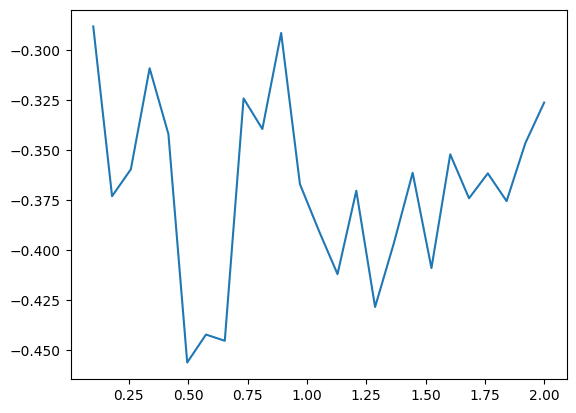

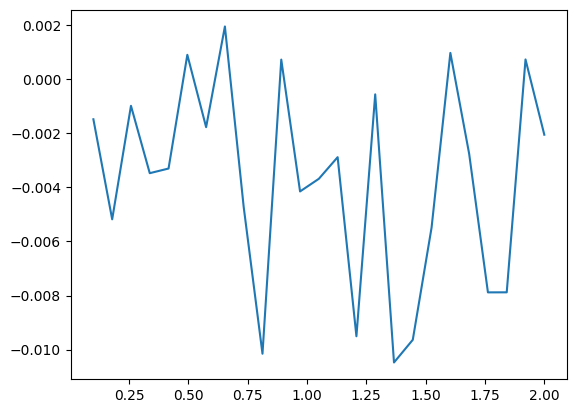

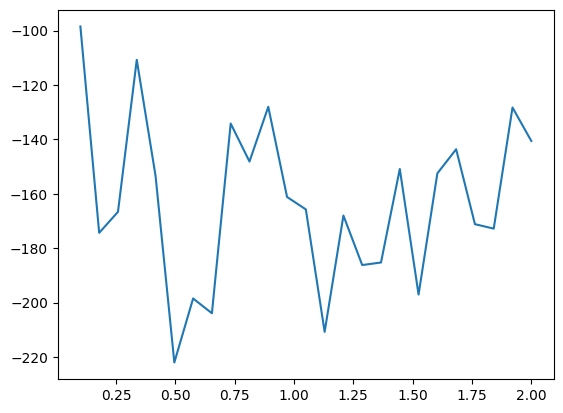

tensor([0.1000, 0.1792, 0.2583, 0.3375, 0.4167, 0.4958, 0.5750, 0.6542, 0.7333,
        0.8125, 0.8917, 0.9708, 1.0500, 1.1292, 1.2083, 1.2875, 1.3667, 1.4458,
        1.5250, 1.6042, 1.6833, 1.7625, 1.8417, 1.9208, 2.0000])

In [95]:
arr = np.array(magnetization)
plt.plot(betas,np.array(arr[:,0]))
plt.show()
plt.plot(betas,np.array(arr[:,1]))
plt.show()
plt.plot(betas,np.array(arr[:,2]))
plt.show()

In [40]:
#plt.plot(betas,np.array(magnetization[0]))
torch.logspace(1,2,10)

tensor([ 10.0000,  12.9155,  16.6810,  21.5443,  27.8256,  35.9381,  46.4159,
         59.9484,  77.4264, 100.0000])

In [ ]:
configuration = torch.arange(0,27)
copy_config = torch.zeros_like(configuration)
var = copy_config.view(3,3,3)
var1 = configuration.view(3,3,3)
var[0,:,:] = - var1[0,:,:] + var1[-1,:,:]
var[:,0,:] = - var1[:,0,:] + var1[:,-1,:]
var[:,:,0] = - var1[:,:,0] + var1[:,:,-1]
var

config_clone = configuration.clone()
new = config_clone.view(3,3,3)
new[0,:,:] = new[-1,:,:]
new[:,0,:] = new[:,-1,:]
new[:,:,0] = new[:,:,-1]
config_clone

In [ ]:
A = torch.zeros(4,4)
A[:+1,:] = 1
A

In [ ]:
torch.arange(0,25)

# No ML

In [114]:
def MCMC(beta, U, BC, energy_parameters, initial_data, time_step, k_max):
    #all operations must act on the whole array of lattices, hence proposed_model_configuration_amongst_zeros and other weird stuff
    
    def gradU(configuration):
        return autograd.grad(U(configuration, energy_parameters), configuration)[0]

    n, N = initial_data.shape

    normal_distribution_for_langevin = multivariate_normal.MultivariateNormal(loc=torch.zeros(N), covariance_matrix=torch.eye(N))

    array_of_model_configurations = torch.zeros(k_max,n,N)
    array_of_model_configurations[0] = initial_data
    array_of_model_configurations.requires_grad = True

    history = torch.zeros(k_max, n)
    #history[k,i] = 0 => Dynamic Langevin step
    #history[k,i] = 1 => Static Langevin step
    #history[k,i] = 2 => Dynamic Flow step
    #history[k,i] = 3 => Static Flow step

    for k in tqdm(range(1,k_max)):
        for i in range(n):
            proposed_model_configuration_amongst_zeros = torch.zeros(k_max,n,N)
            proposed_model_configuration_amongst_zeros[k,i] = (array_of_model_configurations[k-1,i]
                                                                    - time_step * gradU(array_of_model_configurations[k-1, i])
                                                                    + torch.sqrt(2*torch.tensor(time_step)) * normal_distribution_for_langevin.sample())

                #proposed_model_configuration_amongst_zeros[k,i] = BC(proposed_model_configuration_amongst_zeros[k,i])

            acceptance_rate = torch.exp(beta*U(array_of_model_configurations[k-1, i], energy_parameters) - beta*U(proposed_model_configuration_amongst_zeros[k, i], energy_parameters))
            if uniform() > acceptance_rate:
                    proposed_model_configuration_amongst_zeros[k,i] = array_of_model_configurations[k-1,i]
                    history[k,i] += 1
            array_of_model_configurations = array_of_model_configurations + proposed_model_configuration_amongst_zeros
        
    return history, array_of_model_configurations.detach()

In [115]:
history, array_of_model_configurations = MCMC(beta, U, BC, energy_parameters, initial_data, time_step, k_max)

100%|█████████████████████████████████████████| 199/199 [00:07<00:00, 27.38it/s]


In [ ]:
def MCMC_magnet(beta):
    history, array_of_model_configurations = MCMC(beta, U, BC, energy_parameters, initial_data, time_step, k_max)
    